In [ ]:
# In a Jupyter Notebook cell
# --- Cell 1: Setup ---
import pandas as pd
import joblib
import json
import sys
import os
from pathlib import Path

# Menambahkan folder utama proyek ke path Python
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from eval.prob_metrics import evaluate_probabilistic_forecasts
from eval.calibration import apply_conformal_calibration
from backtest.simulate import simulate_trading, calculate_performance_metrics

In [ ]:
# --- Cell 2: Load Backtest Results ---
MODEL_NAME = 'lgbm_quantile'
HORIZON = 180
# Menggunakan project_root dari sel pertama untuk membangun path yang benar
preds_path = Path(project_root) / f"artifacts/backtest/{MODEL_NAME}_h{HORIZON}_predictions.parquet"

if not preds_path.exists():
    print("Backtest results not found. Run `python -m backtest.walkforward ...` first.")
else:
    preds = pd.read_parquet(preds_path)
    print("Backtest results loaded successfully.")
    print(preds.head())

Backtest results loaded successfully.
            log_return_180d    q_0.05    q_0.25     q_0.5    q_0.75    q_0.95  \
Timestamp                                                                       
2017-01-01         0.928002  0.628638  0.763008  0.793648  0.793648  0.944619   
2017-01-02         0.879088  0.626470  0.760588  0.774248  0.774248  0.937987   
2017-01-03         0.892139  0.631986  0.764169  0.798104  0.798104  0.944474   
2017-01-04         0.811188 -0.149874  0.528891  0.528891  0.719207  0.922318   
2017-01-05         0.962476  0.410866  0.544886  0.544886  0.747657  1.000202   

              Close  
Timestamp            
2017-01-01   996.22  
2017-01-02  1012.99  
2017-01-03  1020.34  
2017-01-04  1134.81  
2017-01-05   979.52  


--- Probabilistic Evaluation (Nominal Coverage: 90%) ---
CRPS: 0.1241
PICP: 0.349
Winkler Score: 3.8155


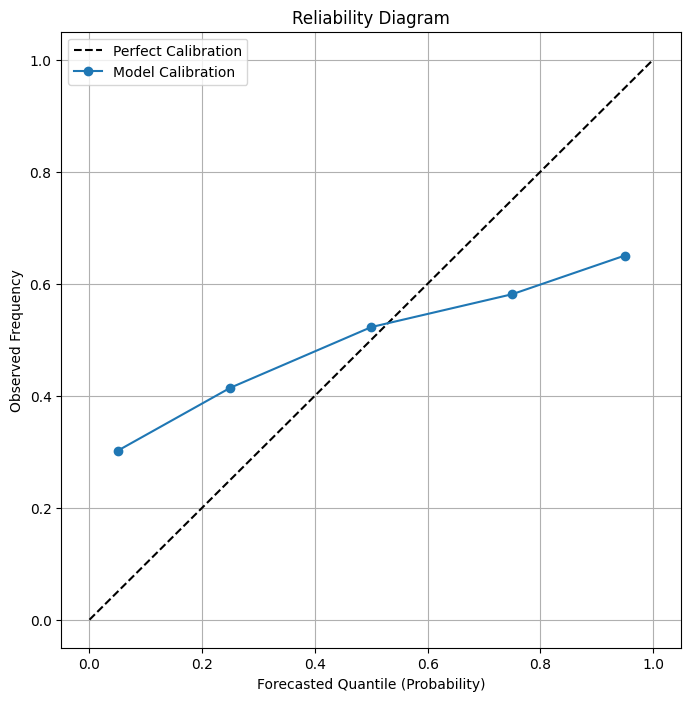

{'CRPS': np.float64(0.12414954067262356),
 'PICP': np.float64(0.3486111111111111),
 'Winkler_Score': np.float64(3.8154986063362077)}

In [ ]:
# --- Cell 3: Evaluate Probabilistic Forecasts ---
with open('../train/config.json', 'r') as f:
    config = json.load(f)

quantiles = config['training']['quantiles']
evaluate_probabilistic_forecasts(preds, quantiles)

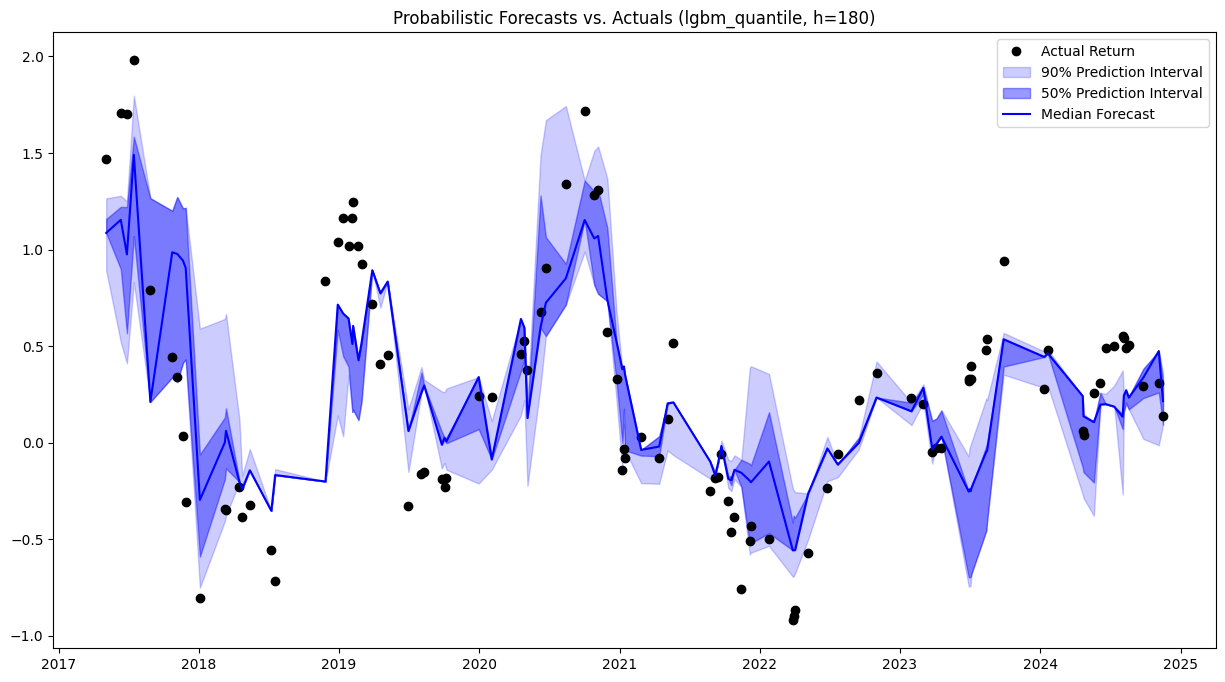

In [ ]:
# --- Cell 4: Plot Forecasts vs. Actuals ---
import matplotlib.pyplot as plt

plot_df = preds.sample(100, random_state=42).sort_index()

plt.figure(figsize=(15, 8))
plt.plot(plot_df.index, plot_df.iloc[:, 0], 'ko', label='Actual Return')
plt.fill_between(
    plot_df.index,
    plot_df['q_0.05'],
    plot_df['q_0.95'],
    color='blue', alpha=0.2, label='90% Prediction Interval'
)
plt.fill_between(
    plot_df.index,
    plot_df['q_0.25'],
    plot_df['q_0.75'],
    color='blue', alpha=0.4, label='50% Prediction Interval'
)
plt.plot(plot_df.index, plot_df['q_0.5'], 'b-', label='Median Forecast')
plt.title(f'Probabilistic Forecasts vs. Actuals ({MODEL_NAME}, h={HORIZON})')
plt.legend()
plt.show()


--- Applying Post-Hoc Calibration ---
Applying conformal calibration...
Conformal adjustment factor (q_hat): 0.4871

--- Evaluation on Calibrated Forecasts ---
--- Probabilistic Evaluation (Nominal Coverage: 90%) ---
CRPS: 0.0918
PICP: 0.639
Winkler Score: 2.2563


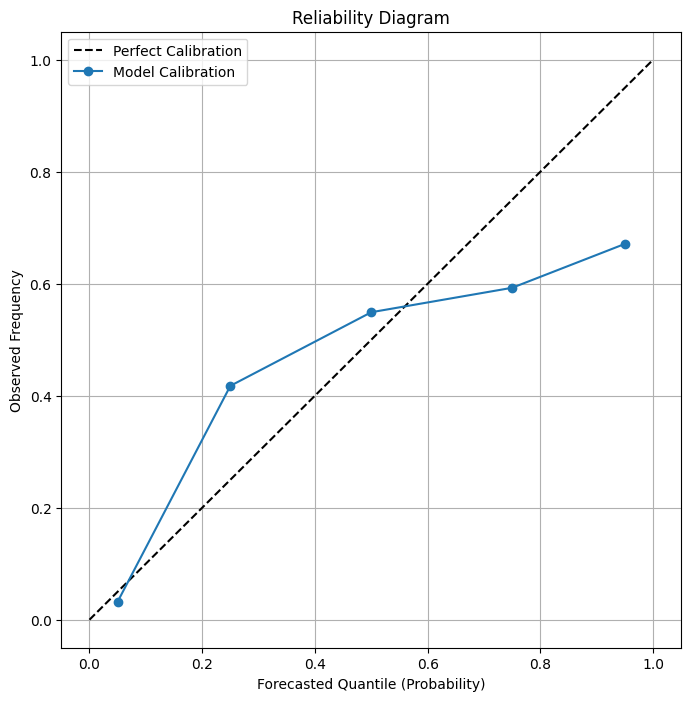

{'CRPS': np.float64(0.09184522330767941),
 'PICP': np.float64(0.6388888888888888),
 'Winkler_Score': np.float64(2.256276337251142)}

In [ ]:
# --- Cell 5: Apply Calibration and Re-evaluate ---
print("\n--- Applying Post-Hoc Calibration ---")
calib_size = int(len(preds) * 0.3)
calib_set = preds.iloc[:calib_size]
test_set = preds.iloc[calib_size:]

calibrated_preds_values = apply_conformal_calibration(
    calib_set.iloc[:, 0].values,
    calib_set.iloc[:, 1:].values,
    test_set.iloc[:, 1:].values,
    quantiles
)
calibrated_preds_df = pd.DataFrame(calibrated_preds_values, index=test_set.index, columns=test_set.columns[1:])
calibrated_results = pd.concat([test_set.iloc[:, 0], calibrated_preds_df], axis=1)

print("\n--- Evaluation on Calibrated Forecasts ---")
evaluate_probabilistic_forecasts(calibrated_results, quantiles)


--- Running Trading Simulation ---
Total Return: 4843.73%
Annualized Return: 63.94%
Annualized Volatility: 38.80%
Sharpe Ratio: 1.65
Max Drawdown: -42.35%


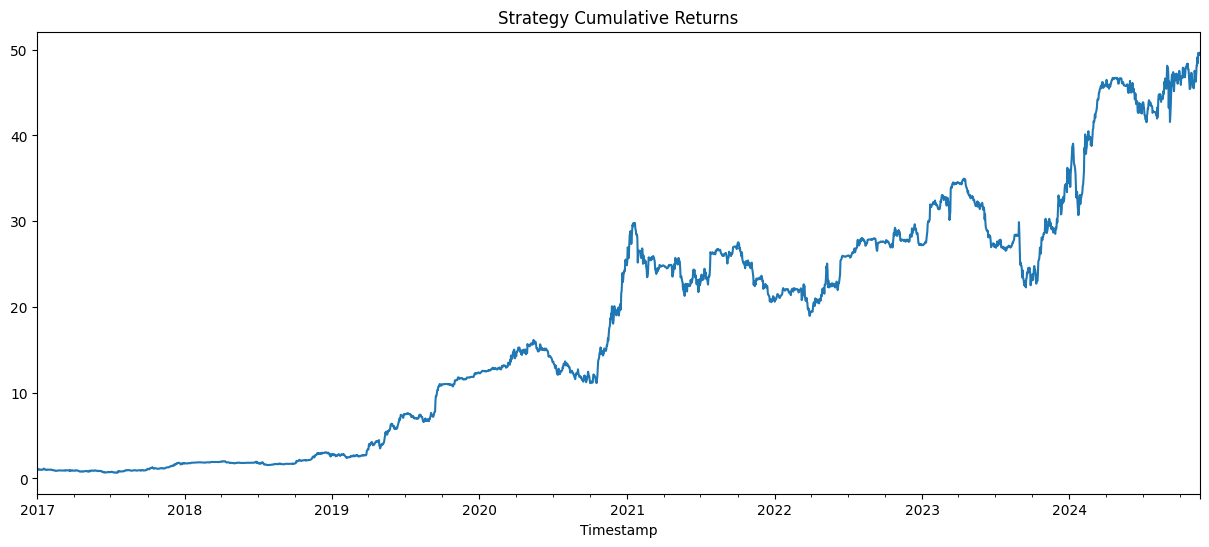

In [ ]:
# --- Cell 6: Run Trading Simulation ---
print("\n--- Running Trading Simulation ---")
sim_returns = simulate_trading(preds, config['backtest']['transaction_cost_pct'])
performance = calculate_performance_metrics(sim_returns)
for key, value in performance.items():
    print(f"{key}: {value}")

plt.figure(figsize=(15, 6))
(1 + sim_returns).cumprod().plot()
plt.title('Strategy Cumulative Returns')
plt.show()